<a href="https://colab.research.google.com/github/swardiantara/fp-dm-2021/blob/main/GRU%2BWord2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
data_traindf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/train.csv')
data_testdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/test.csv')
data_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/merged.csv')

In [ ]:
data_traindf.head()

,sentence #,word,pos,tag,word_idx,tag_idx
0,1,Berikut,PROPN,O,805,4
1,1,adalah,AUX,O,5456,4
2,1,tujuh,NUM,O,3291,4
3,1,kota,NOUN,O,7522,4
4,1,di,ADP,O,2096,4


In [ ]:
data_testdf.head()

,sentence #,word,pos,tag,word_idx,tag_idx
0,1,Presiden,PROPN,O,79,4
1,1,terpilih,VERB,O,7980,4
2,1,Joko,PROPN,B-PER,2526,2
3,1,Widodo,PROPN,I-PER,7595,5
4,1,mengungkapkan,VERB,O,3199,4


In [ ]:
data_merged.head()

,sentence #,word,pos,tag,word_idx,tag_idx
0,1,Berikut,PROPN,O,805,4
1,1,adalah,AUX,O,5456,4
2,1,tujuh,NUM,O,3291,4
3,1,kota,NOUN,O,7522,4
4,1,di,ADP,O,2096,4


In [ ]:
print("Train Shape : ", data_traindf.shape)
print("Test Shape : ", data_testdf.shape)
print("Merged Shape : ", data_merged.shape)

Train Shape :  (30248, 6)
Test Shape :  (18451, 6)
Merged Shape :  (48699, 6)


In [ ]:
data_traindf["tag"].value_counts()

O        26728
B-PER      896
B-ORG      721
B-LOC      579
I-ORG      577
I-PER      486
I-LOC      261
Name: tag, dtype: int64

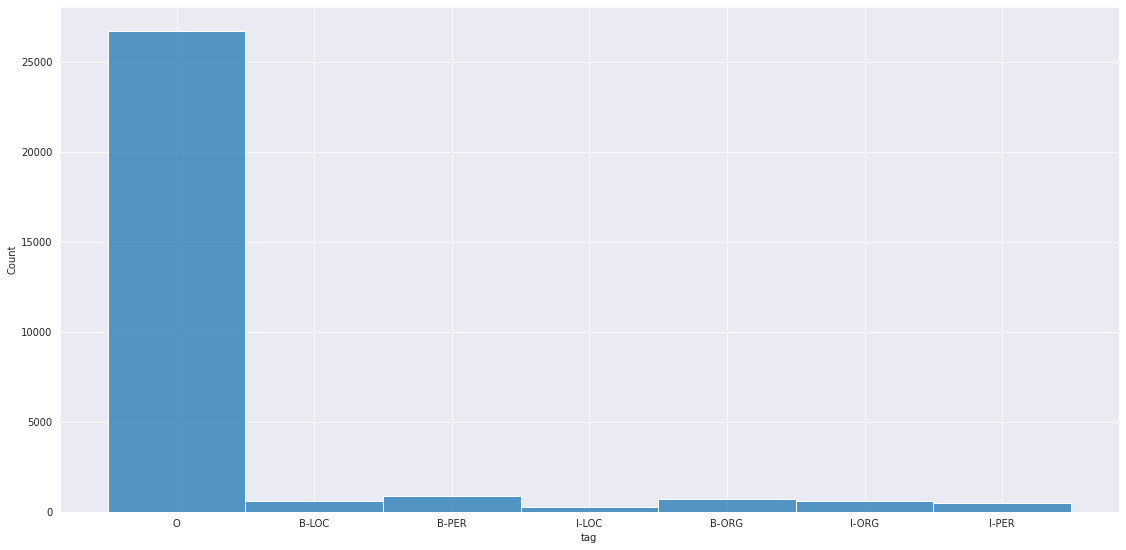

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(data_traindf['tag'])
plt.tight_layout(pad=2)
plt.show()

In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['word'].to_list()))
    else:
        vocab = list(set(data['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok, vocab

In [ ]:
token2idx, idx2token, word_vocab = get_dict_map(data_merged, 'token')
tag2idx, idx2tag, tag_vocab = get_dict_map(data_merged, 'tag')
word_vocab.append("ENDPAD")

In [ ]:
data_traindf_fillna = data_traindf.fillna(method='ffill', axis=0)
data_testdf_fillna = data_testdf.fillna(method='ffill', axis=0)
data_merged_fillna = data_merged.fillna(method='ffill', axis=0)

In [ ]:
data_traindf_group = data_traindf_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))
data_testdf_group = data_testdf_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))
data_merged_group = data_merged_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data_traindf_group.head()

,sentence #,word,tag,word_idx,tag_idx
0,1,"[Berikut, adalah, tujuh, kota, di, Indonesia, ...","[O, O, O, O, O, B-LOC, O, O, O, O, O, O, O]","[805, 5456, 3291, 7522, 2096, 3518, 4477, 5271...","[4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]"
1,2,"[Soal, calon, presiden, itu, urusan, nanti, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-P...","[528, 7255, 4628, 7226, 2653, 2768, 3948, 4477...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, ..."
2,3,"[Kalau, itu, tanya, PPP, saja, ,, ujar, Nasir,...","[O, O, O, B-ORG, O, O, O, B-PER, O, O, O, O, O...","[4780, 7226, 7466, 827, 3799, 3948, 5916, 2756...","[4, 4, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, ..."
3,4,"[Jokowi, bisa, mengatakan, mencabut, pengaduan...","[B-PER, O, O, O, O, O, O, O, O, O, O]","[8070, 1388, 2557, 3049, 8366, 418, 7443, 3898...","[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"
4,5,"[Akbar, menyebutkan, pemerintahan, Jokowi-JK, ...","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[5096, 2156, 1826, 2562, 7625, 4386, 4784, 200...","[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [ ]:
maxlen_merged = max([len(s) for s in data_merged_group['word_idx'].tolist()])
maxlen_train = max([len(s) for s in data_traindf_group['word_idx'].tolist()])
maxlen_test = max([len(s) for s in data_testdf_group['word_idx'].tolist()])

In [ ]:
print("Merged :", maxlen_merged)
print("Train :", maxlen_train)
print("Test :", maxlen_test)

Merged : 112
Train : 69
Test : 94


In [ ]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad(dataset_grouped, word_vocab, tag_vocab, maxlen):

    #get max token and tag length
    n_token = len(word_vocab)
    n_tag = len(tag_vocab)

    #Pad tokens (X var)    
    tokens = dataset_grouped['word_idx'].tolist()
    # maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset_grouped['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    # #Split train, test and validation set
    # tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    # train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    # print(
    #     'train_tokens length:', len(train_tokens),
    #     '\ntrain_tags length:', len(train_tags),
    #     '\ntest_tokens length:', len(test_tokens),
    #     '\ntest_tags:', len(test_tags),
    #     '\nval_tokens:', len(val_tokens),
    #     '\nval_tags:', len(val_tags),
    # )
    
    return pad_tokens, pad_tags

In [ ]:
train_tokens, train_tags = get_pad(data_traindf_group, word_vocab, tag_vocab, maxlen_merged)
test_tokens,  test_tags = get_pad(data_testdf_group, word_vocab, tag_vocab, maxlen_merged)
train_tags = np.array(train_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'test_tags: ',test_tags.shape)

train_tags:  (1464, 112, 7) test_tags:  (509, 112, 7)


In [ ]:
train_tags

array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1.

In [ ]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

163968


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

{0: 32.488210818307905, 1: 40.4559585492228, 2: 26.142857142857142, 3: 40.596187175043326, 4: 0.876384316073032, 5: 0.1745376510737225, 6: 89.74712643678161}
(1464, 112)
(1464, 112)


In [ ]:
from tensorflow import keras
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from keras.models import Sequential

input_dim = len(word_vocab)+1
output_dim = 64
input_length = maxlen_merged
n_tags = len(tag2idx)
input_we = len(token2idx)+1

Word2Vec Embedding

In [ ]:
from gensim.models import Word2Vec
import os

word_list = data_merged_group['word'].to_list()
model = Word2Vec(word_list, size=100, window=5, min_count=1, workers=3, iter=100, sg=1)
os.makedirs("models/word_embeddings/w2v", exist_ok=True)
model.save("models/word_embeddings/w2v/w2v")

In [ ]:
w2v = model.wv
w2v.similar_by_word('presiden', topn=5)

[('wakil', 0.6009534001350403),
 ('non-kader', 0.5901608467102051),
 ('berlaga', 0.5777568817138672),
 ('mengsung', 0.5743512511253357),
 ('rencanannya', 0.5727461576461792)]

In [ ]:
w2v.wv['presiden']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([-0.33861017, -0.15919772, -0.5085625 ,  0.28679127, -0.08748044,
        0.28951097,  0.10694607, -0.24558802, -0.3221832 ,  0.6610796 ,
        0.40634963,  0.6204648 , -0.1524966 ,  1.2640271 , -0.08992121,
       -0.20622197,  2.1101155 ,  0.01704656, -0.9256883 ,  0.5832205 ,
       -0.17678824,  0.30364504,  0.14498433,  0.65229034, -0.5460941 ,
        0.17273049,  0.5453805 , -0.217207  , -0.5695073 ,  0.47615537,
       -0.15498929,  1.1996154 ,  0.85513   , -0.22525482,  0.13937701,
        0.7673196 , -0.18618937,  0.6772297 , -1.1902612 , -1.077435  ,
        0.07565299, -0.53449255,  0.11000205, -0.4539212 ,  0.28334236,
       -1.8656824 , -0.19900034, -0.38184524, -0.02024153, -0.3969251 ,
        0.71881413, -0.13420558, -1.1197802 ,  0.98762304, -0.30707747,
       -0.7388363 ,  0.09478496, -0.2057116 , -1.1685028 ,  1.0042707 ,
        0.6303559 ,  0.5815512 ,  0.7313241 , -0.46611935, -0.6121647 ,
        0.18493123, -0.2815457 ,  0.25172365, -0.5304889 ,  0.16

In [ ]:
from gensim.models import KeyedVectors

embeddings_dictionary = KeyedVectors.load('models/word_embeddings/w2v/w2v')

In [ ]:
embedding_matrix = np.zeros((len(token2idx) + 1, 100))
for word, i in token2idx.items():
  # try:
  #   embedding_vector = embeddings_dictionary[word]
  # except:
  #   embedding_vector = np.random.normal(0, np.sqrt(0.25), 100)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(8543, 100)

In [ ]:
embedding_layer = Embedding(input_we,
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=maxlen_merged,
                            trainable=False)

In [ ]:
def get_gru_model():
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Embedding(input_we, embedding_matrix.shape[1], input_length=maxlen_merged))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(n_tags, activation = "softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

# class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 32.488210818307905, 1: 40.4559585492228, 2: 26.142857142857142, 3: 40.596187175043326, 4: 0.876384316073032, 5: 0.1745376510737225, 6: 89.74712643678161}
(1464, 112)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

nlp_model = get_gru_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=25, validation_split=0.2, sample_weight = sample_weights) 

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 112, 100)          854300    
                                                                 
 gru_25 (GRU)                (None, 112, 128)          88320     
                                                                 
 dropout_25 (Dropout)        (None, 112, 128)          0         
                                                                 
 dense_26 (Dense)            (None, 112, 7)            903       
                                                                 
Total params: 943,523
Trainable params: 89,223
Non-trainable params: 854,300
_________________________________________________________________
Epoch 1/25
19/19 [==============================] - 6s 236ms/step - loss: 1.8127 - accuracy: 0.7211 - val_loss: 1.5118 - val_accuracy: 0.9195
Epoch 2/25
19/19 [==============

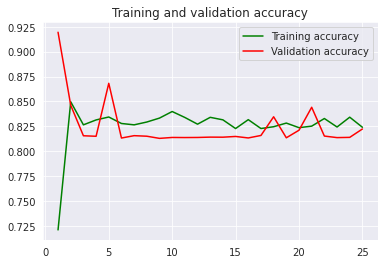

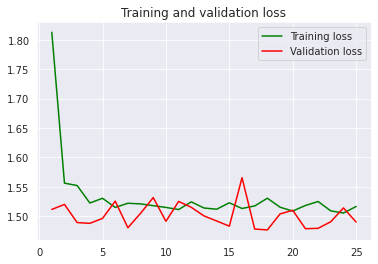

In [ ]:
 # Plot results
import matplotlib.pyplot as plt

accuracy = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = nlp_model.predict(test_tokens)
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(509, 112) (509, 112)
16/16 [==============================] - 1s 32ms/step - loss: 0.2582 - accuracy: 0.9305


[0.25815173983573914, 0.9305360913276672]

In [ ]:
y_test_list = []
y_pred_list = []
for row in range(0, y_test.shape[0]):
  y_pred_list = np.concatenate((y_pred_list, y_pred[row]), axis=0)
  y_test_list = np.concatenate((y_test_list, y_test[row]), axis=0)
  # y_test_list = y_test_list + y_test[row]

In [ ]:
data_prediction = pd.DataFrame({'actual_class': y_test_list, 'predicted_class': y_pred_list})
data_prediction['actual_class'] = data_prediction['actual_class'].map(idx2tag)
data_prediction['predicted_class'] = data_prediction['predicted_class'].map(idx2tag)

In [ ]:
data_prediction

,actual_class,predicted_class
0,B-ORG,B-ORG
1,B-ORG,B-PER
2,B-PER,B-PER
3,O,B-PER
4,B-ORG,B-PER
...,...,...
57003,O,O
57004,O,O
57005,O,O
57006,O,O


In [ ]:
confusion_matrix = pd.crosstab(data_prediction['predicted_class'], data_prediction['actual_class'])
confusion_matrix

actual_class,B-LOC,B-ORG,B-PER,I-LOC,I-ORG,I-PER,O
predicted_class,,,,,,,
B-LOC,370,443,39,15,3,3,16
B-ORG,122,13125,214,79,19,31,185
B-PER,27,849,406,20,5,6,99
I-LOC,11,183,18,259,4,2,14
I-ORG,11,247,7,13,124,12,9
I-PER,21,331,13,5,4,200,2
O,28,790,39,20,0,1,38564


In [ ]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(data_prediction['actual_class'], data_prediction['predicted_class'], output_dict=True)).T

,precision,recall,f1-score,support
B-LOC,0.416198,0.627119,0.500338,590.000000
B-ORG,0.952813,0.821956,0.882561,15968.000000
B-PER,0.287535,0.551630,0.378026,736.000000
I-LOC,0.527495,0.630170,0.574279,411.000000
I-ORG,0.293144,0.779874,0.426117,159.000000
I-PER,0.347222,0.784314,0.481348,255.000000
O,0.977739,0.991643,0.984642,38889.000000
accuracy,0.930536,0.930536,0.930536,0.930536
macro avg,0.543164,0.740958,0.603902,57008.000000
weighted avg,0.948059,0.930536,0.936437,57008.000000
